# Recommendation System of an E-commerce Store

### Import Libraries and Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

### Load and Explore

In [5]:
# Load datasets
transaction_data =  pd.read_csv('datasets/transaction_data.csv')
product = pd.read_csv('datasets/product.csv')
demo = pd.read_csv('datasets/hh_demographic.csv')

# Filter the data to keep only rows for the first 180 days (6 months)
transaction_data = transaction_data[transaction_data['DAY'] <= 180]

In [6]:
print("Transaction Data Shape:", transaction_data.shape)
print("\nTransaction Data Sample:")
print(transaction_data.head())

Transaction Data Shape: (466675, 12)

Transaction Data Sample:
   household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
0           2375  26984851472    1     1004906         1         1.39   
1           2375  26984851472    1     1033142         1         0.82   
2           2375  26984851472    1     1036325         1         0.99   
3           2375  26984851472    1     1082185         1         1.21   
4           2375  26984851472    1     8160430         1         1.50   

   STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  COUPON_MATCH_DISC  
0       364        -0.60        1631        1          0.0                0.0  
1       364         0.00        1631        1          0.0                0.0  
2       364        -0.30        1631        1          0.0                0.0  
3       364         0.00        1631        1          0.0                0.0  
4       364        -0.39        1631        1          0.0                0.0  


In [7]:
print(transaction_data.tail())

        household_key    BASKET_ID  DAY  PRODUCT_ID  QUANTITY  SALES_VALUE  \
469973             16  29396266544  180     2495324         1         1.69   
469974             16  29396266544  180     2496543         1         1.34   
469975             16  29396266544  180     2597234         1         2.00   
469976             16  29396266544  180     2661798         1         4.99   
469977             16  29396266544  180     2685796         1         2.79   

        STORE_ID  RETAIL_DISC  TRANS_TIME  WEEK_NO  COUPON_DISC  \
469973      3316         0.00        1612       26          0.0   
469974      3316         0.00        1612       26          0.0   
469975      3316        -0.89        1612       26          0.0   
469976      3316         0.00        1612       26          0.0   
469977      3316        -0.70        1612       26          0.0   

        COUPON_MATCH_DISC  
469973                0.0  
469974                0.0  
469975                0.0  
469976          

In [8]:
print("Household Demographics Shape:", demo.shape)
print("\nHousehold Demographics Sample:")
print(demo.head())

Household Demographics Shape: (801, 8)

Household Demographics Sample:
  classification_1 classification_2 classification_3 HOMEOWNER_DESC  \
0       Age Group6                X           Level4      Homeowner   
1       Age Group4                X           Level5      Homeowner   
2       Age Group2                Y           Level3        Unknown   
3       Age Group2                Y           Level6      Homeowner   
4       Age Group4                Z           Level5      Homeowner   

  classification_5 classification_4 KID_CATEGORY_DESC  household_key  
0           Group5                2      None/Unknown              1  
1           Group5                2      None/Unknown              7  
2           Group4                3                 1              8  
3           Group4                4                 2             13  
4           Group3                1      None/Unknown             16  


In [9]:
print("Product Data Shape:", product.shape)
print("\nProduct Data Sample:")
print(product.head())

Product Data Shape: (92353, 7)

Product Data Sample:
   PRODUCT_ID  MANUFACTURER    DEPARTMENT     BRAND            COMMODITY_DESC  \
0       25671             2       GROCERY  National                  FRZN ICE   
1       26081             2  MISC. TRANS.  National  NO COMMODITY DESCRIPTION   
2       26093            69        PASTRY   Private                     BREAD   
3       26190            69       GROCERY   Private      FRUIT - SHELF STABLE   
4       26355            69       GROCERY   Private             COOKIES/CONES   

            SUB_COMMODITY_DESC CURR_SIZE_OF_PRODUCT  
0          ICE - CRUSHED/CUBED                22 LB  
1  NO SUBCOMMODITY DESCRIPTION                       
2         BREAD:ITALIAN/FRENCH                       
3                  APPLE SAUCE                50 OZ  
4            SPECIALTY COOKIES                14 OZ  


### Data Preprocessing

In [11]:
# Merge transaction with product info
data = transaction_data.merge(product, on='PRODUCT_ID', how='left')

# Merge with household demographics
data = data.merge(demo, on='household_key', how='left')

print(f"Merged data shape: {data.shape}")
print("\nMerged data sample:")
print(data.head(5).T)

Merged data shape: (466675, 25)

Merged data sample:
                                               0                        1  \
household_key                               2375                     2375   
BASKET_ID                            26984851472              26984851472   
DAY                                            1                        1   
PRODUCT_ID                               1004906                  1033142   
QUANTITY                                       1                        1   
SALES_VALUE                                 1.39                     0.82   
STORE_ID                                     364                      364   
RETAIL_DISC                                 -0.6                      0.0   
TRANS_TIME                                  1631                     1631   
WEEK_NO                                        1                        1   
COUPON_DISC                                  0.0                      0.0   
COUPON_MATCH_DISC      

In [12]:
# Check for missing values
print("Missing values:")
print(data.isnull().sum())

Missing values:
household_key                0
BASKET_ID                    0
DAY                          0
PRODUCT_ID                   0
QUANTITY                     0
SALES_VALUE                  0
STORE_ID                     0
RETAIL_DISC                  0
TRANS_TIME                   0
WEEK_NO                      0
COUPON_DISC                  0
COUPON_MATCH_DISC            0
MANUFACTURER                 0
DEPARTMENT                   0
BRAND                        0
COMMODITY_DESC               0
SUB_COMMODITY_DESC           0
CURR_SIZE_OF_PRODUCT         0
classification_1        231038
classification_2        231038
classification_3        231038
HOMEOWNER_DESC          231038
classification_5        231038
classification_4        231038
KID_CATEGORY_DESC       231038
dtype: int64


In [13]:
# Fill missing values
data = data.fillna('Unknown')

In [14]:
print("\nData types:")
print(data.dtypes)


Data types:
household_key             int64
BASKET_ID                 int64
DAY                       int64
PRODUCT_ID                int64
QUANTITY                  int64
SALES_VALUE             float64
STORE_ID                  int64
RETAIL_DISC             float64
TRANS_TIME                int64
WEEK_NO                   int64
COUPON_DISC             float64
COUPON_MATCH_DISC       float64
MANUFACTURER              int64
DEPARTMENT               object
BRAND                    object
COMMODITY_DESC           object
SUB_COMMODITY_DESC       object
CURR_SIZE_OF_PRODUCT     object
classification_1         object
classification_2         object
classification_3         object
HOMEOWNER_DESC           object
classification_5         object
classification_4         object
KID_CATEGORY_DESC        object
dtype: object


### Exploratory Data Analysis

In [16]:
print(f"Unique Households: {data['household_key'].nunique()}")
print(f"Unique Products: {data['PRODUCT_ID'].nunique()}")
print(f"Total Transactions: {len(data)}")
print(f"Date Range: Week {data['WEEK_NO'].min()} to Week {data['WEEK_NO'].max()}")

Unique Households: 2494
Unique Products: 43434
Total Transactions: 466675
Date Range: Week 1 to Week 26


In [17]:
# Top products by sales value
print("Top 10 Products by Sales Value:")
top_products = data.groupby('PRODUCT_ID')['SALES_VALUE'].sum().sort_values(ascending=False).head(10)
print(top_products)

Top 10 Products by Sales Value:
PRODUCT_ID
6534178    77708.95
1029743     7648.30
6533889     6806.61
1082185     5374.01
916122      5363.33
1106523     4961.99
6534166     4729.45
5569230     4273.88
995242      3835.43
1044078     3477.64
Name: SALES_VALUE, dtype: float64


In [18]:
# Top departments
print("Top 10 Departments by Sales Value:")
top_departments = data.groupby('DEPARTMENT')['SALES_VALUE'].sum().sort_values(ascending=False).head(10)
print(top_departments)

Top 10 Departments by Sales Value:
DEPARTMENT
GROCERY            720299.39
DRUG GM            185437.45
MEAT               100921.75
PRODUCE            100065.96
KIOSK-GAS           82303.87
MEAT-PCKGD          78433.58
DELI                47675.78
PASTRY              21377.49
MISC SALES TRAN     16601.25
NUTRITION           15498.18
Name: SALES_VALUE, dtype: float64


In [19]:
# Top departments
print("Top 10 Households by Sales Value:")
top_households = data.groupby('household_key')['SALES_VALUE'].sum().sort_values(ascending=False).head(10)
print(top_households)

Top 10 Households by Sales Value:
household_key
2459    5667.90
2322    4815.70
1609    4729.68
718     4710.01
1803    4204.98
235     4059.68
2110    3811.39
982     3804.07
1023    3715.11
2185    3608.83
Name: SALES_VALUE, dtype: float64


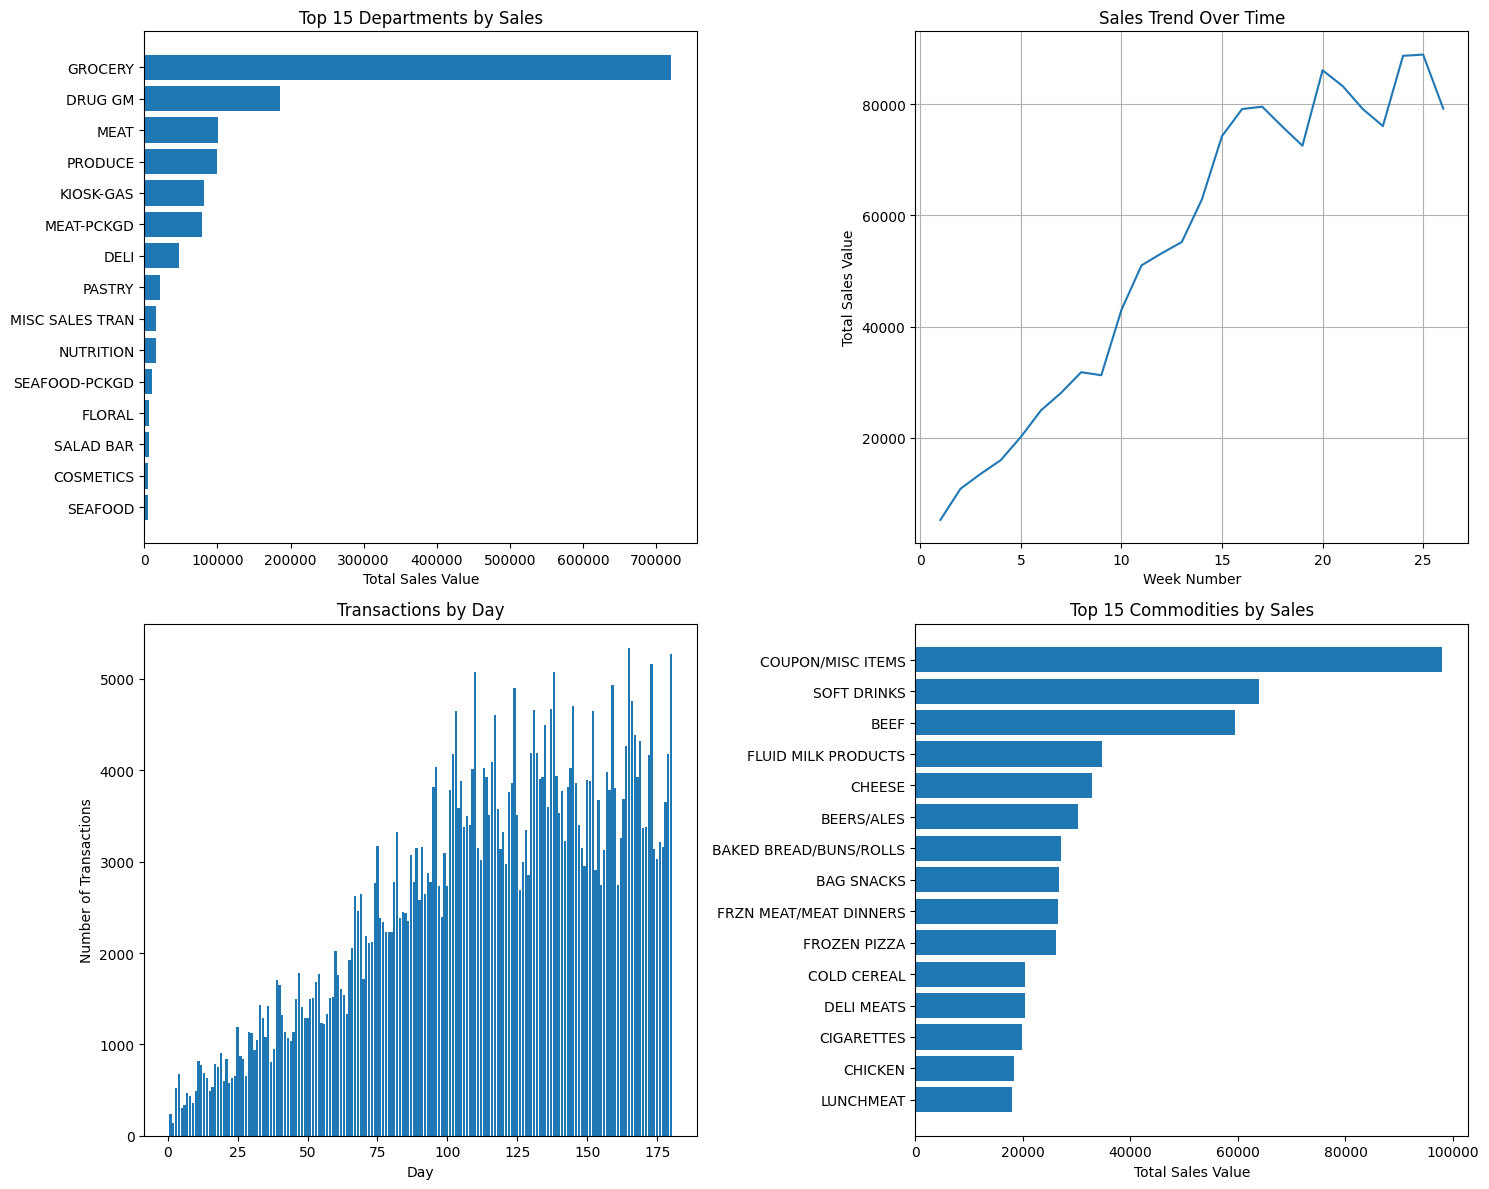

In [20]:
# Visualize purchase patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sales by Department
dept_sales = data.groupby('DEPARTMENT')['SALES_VALUE'].sum().sort_values(ascending=False).head(15)
axes[0, 0].barh(range(len(dept_sales)), dept_sales.values)
axes[0, 0].set_yticks(range(len(dept_sales)))
axes[0, 0].set_yticklabels(dept_sales.index)
axes[0, 0].set_xlabel('Total Sales Value')
axes[0, 0].set_title('Top 15 Departments by Sales')
axes[0, 0].invert_yaxis()

# Purchases over time
weekly_sales = data.groupby('WEEK_NO')['SALES_VALUE'].sum()
axes[0, 1].plot(weekly_sales.index, weekly_sales.values)
axes[0, 1].set_xlabel('Week Number')
axes[0, 1].set_ylabel('Total Sales Value')
axes[0, 1].set_title('Sales Trend Over Time')
axes[0, 1].grid(True)

# Transaction distribution by day
day_counts = data['DAY'].value_counts()
axes[1, 0].bar(day_counts.index, day_counts.values)
axes[1, 0].set_xlabel('Day')
axes[1, 0].set_ylabel('Number of Transactions')
axes[1, 0].set_title('Transactions by Day')

# Quantity distribution
com_sales = data.groupby('COMMODITY_DESC')['SALES_VALUE'].sum().sort_values(ascending=False).head(15)
axes[1, 1].barh(range(len(com_sales)), com_sales.values)
axes[1, 1].set_yticks(range(len(com_sales)))
axes[1, 1].set_yticklabels(com_sales.index)
axes[1, 1].set_xlabel('Total Sales Value')
axes[1, 1].set_title('Top 15 Commodities by Sales')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.show()

### User-Item Interaction Matrix

In [22]:
# Create user-item matrix for collaborative filtering
# Aggregate purchases by household and product (sum of sales value)
user_item_matrix = data.groupby(['household_key', 'PRODUCT_ID'])['SALES_VALUE'].sum().reset_index()

# Create pivot table
user_item_pivot = user_item_matrix.pivot(
    index='household_key', 
    columns='PRODUCT_ID', 
    values='SALES_VALUE'
).fillna(0)

print(f"\nUser-Item Matrix Shape: {user_item_pivot.shape}")
print(f"Sparsity: {(1 - (user_item_pivot > 0).sum().sum() / (user_item_pivot.shape[0] * user_item_pivot.shape[1])) * 100:.2f}%")

# Create binary matrix for implicit feedback
user_item_binary = (user_item_pivot > 0).astype(int)

print(f"\nNumber of interactions: {(user_item_binary.sum().sum())}")
print(f"Average items per user: {user_item_binary.sum(axis=1).mean():.2f}")
print(f"Average users per item: {user_item_binary.sum(axis=0).mean():.2f}")


User-Item Matrix Shape: (2494, 43434)
Sparsity: 99.69%

Number of interactions: 338409
Average items per user: 135.69
Average users per item: 7.79


### Train-Test Split for Evaluation

In [24]:
# Temporal split (earlier weeks for training, later weeks for testing)
split_week = int(data['WEEK_NO'].quantile(0.7))  # 70-30 split

train_data = data[data['WEEK_NO'] <= split_week].copy()
test_data = data[data['WEEK_NO'] > split_week].copy()

print(f"Split week: {split_week}")
print(f"Training data: {len(train_data)} transactions")
print(f"Testing data: {len(test_data)} transactions")
print(f"Training weeks: {train_data['WEEK_NO'].min()} to {train_data['WEEK_NO'].max()}")
print(f"Testing weeks: {test_data['WEEK_NO'].min()} to {test_data['WEEK_NO'].max()}")

# Create train user-item matrix
train_matrix = train_data.groupby(['household_key', 'PRODUCT_ID'])['SALES_VALUE'].sum().reset_index()
train_pivot = train_matrix.pivot(
    index='household_key', 
    columns='PRODUCT_ID', 
    values='SALES_VALUE'
).fillna(0)

print(f"\nTrain matrix shape: {train_pivot.shape}")

Split week: 21
Training data: 333497 transactions
Testing data: 133178 transactions
Training weeks: 1 to 21
Testing weeks: 22 to 26

Train matrix shape: (2493, 38047)


### Content-Based Filtering - Product Feature Matrix

In [26]:
# Create product feature matrix
# One-hot encode categorical features
product_features = product.copy()

# Create feature columns
features_to_encode = ['DEPARTMENT', 'MANUFACTURER', 'BRAND', 'COMMODITY_DESC', 'SUB_COMMODITY_DESC']

# One-hot encode
product_encoded = pd.get_dummies(
    product_features[['PRODUCT_ID'] + features_to_encode], 
    columns=features_to_encode
)

# Set product_id as index
product_encoded.set_index('PRODUCT_ID', inplace=True)

print(f"Product feature matrix shape: {product_encoded.shape}")
print(f"Number of features: {product_encoded.shape[1]}")
print(f"Memory usage: {product_encoded.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

Product feature matrix shape: (92353, 9213)
Number of features: 9213
Memory usage: 812.14 MB


In [27]:
# Convert to sparse matrix for memory efficiency
from scipy.sparse import csr_matrix
product_encoded_sparse = csr_matrix(product_encoded.values)

print(f"Sparse matrix memory usage: ~{product_encoded_sparse.data.nbytes / 1024**2:.2f} MB")

Sparse matrix memory usage: ~0.44 MB


### Content-Based Recommendations Function

In [29]:
def get_similar_products_sparse(product_id, product_encoded_df, product_encoded_sparse, n_similar=20):
    """
    Calculate similarity for a specific product on-demand for memory efficiency
    
    Parameters:
    - product_id: Product to find similar items for
    - product_encoded_df: DataFrame with product features (for index)
    - product_encoded_sparse: Sparse matrix of product features
    - n_similar: Number of similar products to return
    
    Returns:
    - Series with similar products and similarity scores
    """
    if product_id not in product_encoded_df.index:
        return pd.Series()
    
    # Get index of product
    product_idx = product_encoded_df.index.get_loc(product_id)
    
    # Get product vector
    product_vector = product_encoded_sparse[product_idx]
    
    # Calculate similarity with all products with cosine similarity
    similarities = cosine_similarity(product_vector, product_encoded_sparse).flatten()
    
    # Create series with product IDs and similarities
    similarity_series = pd.Series(similarities, index=product_encoded_df.index)
    
    # Remove the product itself and sort
    similarity_series = similarity_series[similarity_series.index != product_id]
    similarity_series = similarity_series.sort_values(ascending=False)
    
    return similarity_series.head(n_similar)

### Content-Based Recommendations for All Users

In [31]:
def get_user_content_recommendations(household_key, train_data, product_encoded_df, 
                                    product_encoded_sparse, n_recommendations=10):
    """
    Get content-based recommendations for a user based on all their purchase history
    (Memory-optimized version)
    
    Parameters:
    - household_key: User to get recommendations for
    - train_data: Training data with purchase history
    - product_encoded_df: DataFrame with product features
    - product_encoded_sparse: Sparse matrix of product features
    - n_recommendations: Number of recommendations to return (top n)
    
    Returns:
    - DataFrame with recommended products and aggregated scores
    """
    # Get user's purchase history
    user_purchases = train_data[train_data['household_key'] == household_key]
    
    if len(user_purchases) == 0:
        return pd.Series()
    
    # Get purchased products with their sales values (as weights)
    purchased_products = user_purchases.groupby('PRODUCT_ID')['SALES_VALUE'].sum().sort_values(ascending=False)
    
    # Limit to top 20 products to save computation
    top_purchases = purchased_products.head(20)
    
    # Aggregate recommendations from top purchased products
    all_recommendations = pd.Series(dtype=float)
    
    for product_id, sales_value in top_purchases.items():
        if product_id in product_encoded_df.index:
            # Get recommendations for this product
            similar = get_similar_products_sparse(
                product_id, 
                product_encoded_df, 
                product_encoded_sparse, 
                n_similar=50
            )
            
            if len(similar) > 0:
                # Weight by sales value
                weighted_similar = similar * sales_value
                
                # Add to aggregated recommendations
                all_recommendations = all_recommendations.add(weighted_similar, fill_value=0)
    
    # Remove already purchased products
    all_recommendations = all_recommendations[~all_recommendations.index.isin(purchased_products.index)]
    
    # Get top N recommendations
    top_recommendations = all_recommendations.sort_values(ascending=False).head(n_recommendations)
    
    return top_recommendations

### Content-based Recommendations for 5 Sample Users

In [33]:
# Generate content-based recommendations for 5 sample users
sample_users = train_data['household_key'].unique()[:5]

content_recommendations = {}

for user in sample_users:
    recs = get_user_content_recommendations(user, train_data, product_encoded, 
                                           product_encoded_sparse, n_recommendations=10)
    content_recommendations[user] = recs
    print(f"\nUser ID {user} - Top 5 Content-based Recommendations:")
    if len(recs) > 0:
        for prod_id, score in recs.head().items():
            prod_info = product[product['PRODUCT_ID'] == prod_id]
            if len(prod_info) > 0:
                dept = prod_info['DEPARTMENT'].values[0]
                cat = prod_info['COMMODITY_DESC'].values[0]
                sub_cat = prod_info['SUB_COMMODITY_DESC'].values[0]
                print(f"  Product {prod_id} (Dept: {dept}, Cat: {cat}, Sub Cat: {sub_cat}): Score = {score:.2f}")
    else:
        print("No recommendations found")


User ID 2375 - Top 5 Content-based Recommendations:
  Product 1688573 (Dept: MEAT, Cat: BEEF, Sub Cat: SELECT BEEF): Score = 23.45
  Product 212350 (Dept: MEAT, Cat: BEEF, Sub Cat: SELECT BEEF): Score = 23.45
  Product 1036686 (Dept: MEAT, Cat: BEEF, Sub Cat: SELECT BEEF): Score = 23.45
  Product 1072760 (Dept: MEAT, Cat: BEEF, Sub Cat: SELECT BEEF): Score = 23.45
  Product 919379 (Dept: MEAT, Cat: BEEF, Sub Cat: SELECT BEEF): Score = 23.45

User ID 1364 - Top 5 Content-based Recommendations:
  Product 1012701 (Dept: MEAT-PCKGD, Cat: FROZEN MEAT, Sub Cat: FRZN BREADED PREPARED CHICK): Score = 34.94
  Product 832492 (Dept: MEAT-PCKGD, Cat: FROZEN MEAT, Sub Cat: FRZN BREADED PREPARED CHICK): Score = 34.94
  Product 881391 (Dept: MEAT-PCKGD, Cat: FROZEN MEAT, Sub Cat: FRZN BREADED PREPARED CHICK): Score = 34.94
  Product 997272 (Dept: MEAT-PCKGD, Cat: FROZEN MEAT, Sub Cat: FRZN BREADED PREPARED CHICK): Score = 34.94
  Product 1091365 (Dept: SALAD BAR, Cat: SALAD BAR, Sub Cat: SALAD BAR F

### Collaborative Filtering - User-User Similarity

In [35]:
# Calculate user-user similarity matrix
# Normalize the matrix (mean-centering)
train_pivot_normalized = train_pivot.sub(train_pivot.mean(axis=1), axis=0)

# Calculate cosine similarity between users
user_similarity = cosine_similarity(train_pivot_normalized)
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=train_pivot.index,
    columns=train_pivot.index
)

print(f"User similarity matrix shape: {user_similarity_df.shape}")

# Display statistics
similarity_values = user_similarity_df.values[np.triu_indices_from(user_similarity_df.values, k=1)]
print(f"\nUser Similarity Statistics:")
print(f"Mean similarity: {similarity_values.mean():.3f}")
print(f"Std similarity: {similarity_values.std():.3f}")
print(f"Min similarity: {similarity_values.min():.3f}")
print(f"Max similarity: {similarity_values.max():.3f}")

User similarity matrix shape: (2493, 2493)

User Similarity Statistics:
Mean similarity: 0.031
Std similarity: 0.103
Min similarity: -0.006
Max similarity: 1.000


### User-User Collaborative Filtering Functions

In [37]:
def predict_user_user_cf(user_id, item_id, user_item_matrix, user_similarity_matrix, k=20):
    """
    Predict rating for user-item pair using user-user collaborative filtering
    
    Parameters:
    - user_id: User to predict for
    - item_id: Item to predict
    - user_item_matrix: User-item interaction matrix
    - user_similarity_matrix: Pre-computed user similarity matrix
    - k: Number of similar users to consider
    
    Returns:
    - Predicted rating for user-user CF
    """
    if user_id not in user_item_matrix.index or item_id not in user_item_matrix.columns:
        return 0
    
    # Get similar users
    similar_users = user_similarity_matrix[user_id].sort_values(ascending=False)[1:k+1]
    
    # Get ratings from similar users for this item
    similar_user_ratings = user_item_matrix.loc[similar_users.index, item_id]
    
    # Filter users who have rated this item
    rated_mask = similar_user_ratings > 0
    
    if rated_mask.sum() == 0:
        # No similar users have rated this item, return global mean
        return user_item_matrix[item_id].mean() if user_item_matrix[item_id].sum() > 0 else 0
    
    # Get similarities for users who rated this item
    similarities = similar_users[rated_mask]
    ratings = similar_user_ratings[rated_mask]
    
    # Weighted average prediction
    if similarities.sum() == 0:
        prediction = ratings.mean()
    else:
        prediction = (ratings * similarities).sum() / similarities.sum()
    
    return prediction

In [38]:
# Generate user-user CF recommendations
def get_user_user_recommendations(user_id, user_item_matrix, user_similarity_matrix, n_recommendations=10, k=20):
    """
    Get top-N recommendations for a user using user-user collaborative filtering
    
    Parameters:
    - user_id: User to get recommendations for
    - user_item_matrix: User-item interaction matrix
    - user_similarity_matrix: Pre-computed user similarity matrix
    - n_recommendations: Number of recommendations to return
    - k: Number of similar users to consider
    
    Returns:
    - Series with recommended items and predicted scores for user-user CF
    """
    if user_id not in user_item_matrix.index:
        return pd.Series()
    
    # Get items user hasn't purchased
    user_purchases = user_item_matrix.loc[user_id]
    unpurchased_items = user_purchases[user_purchases == 0].index
    
    # Predict ratings for unpurchased items
    predictions = {}
    for item in unpurchased_items:
        pred = predict_user_user_cf(user_id, item, user_item_matrix, user_similarity_matrix, k=k)
        predictions[item] = pred
    
    # Sort and return top N
    recommendations = pd.Series(predictions).sort_values(ascending=False).head(n_recommendations)
    
    return recommendations

### User-User Collaborative Filtering Top 5 Sample User Predictions

In [40]:
# Test user-user CF
user_user_recommendations = {}

for user in sample_users:
    if user in train_pivot.index:
        recs = get_user_user_recommendations(user, train_pivot, user_similarity_df, n_recommendations=10, k=20)
        
        user_user_recommendations[user] = recs
        print(f"\nUser {user} - Top 5 User-User CF Recommendations:")
        if len(recs) > 0:
            for prod_id, score in recs.head().items():
                prod_info = product[product['PRODUCT_ID'] == prod_id]
                if len(prod_info) > 0:
                    dept = prod_info['DEPARTMENT'].values[0]
                    cat = prod_info['COMMODITY_DESC'].values[0]
                    sub_cat = prod_info['SUB_COMMODITY_DESC'].values[0]
                    print(f"  Product {prod_id} (Dept: {dept}, Cat: {cat}, Sub Cat: {sub_cat}): Score = {score:.2f}")
        else:
            print("  No recommendations found")


User 2375 - Top 5 User-User CF Recommendations:
  Product 6534178 (Dept: KIOSK-GAS, Cat: COUPON/MISC ITEMS, Sub Cat: GASOLINE-REG UNLEADED): Score = 58.06
  Product 982211 (Dept: DRUG GM, Cat: IN-STORE PHOTOFINISHING, Sub Cat: ONE HOUR PROCESSING): Score = 28.52
  Product 896615 (Dept: DRUG GM, Cat: IN-STORE PHOTOFINISHING, Sub Cat: OVERNIGHT PROCESSING): Score = 27.96
  Product 998171 (Dept: MEAT, Cat: BEEF, Sub Cat: PRIMAL): Score = 25.93
  Product 9835619 (Dept: DELI, Cat: CHICKEN/POULTRY, Sub Cat: CHIX:FRD 8PC/CUT UP (HOT)): Score = 23.96

User 1364 - Top 5 User-User CF Recommendations:
  Product 6534178 (Dept: KIOSK-GAS, Cat: COUPON/MISC ITEMS, Sub Cat: GASOLINE-REG UNLEADED): Score = 50.46
  Product 900248 (Dept: GROCERY, Cat: LAUNDRY DETERGENTS, Sub Cat: POWDER LAUNDRY DETERGENT): Score = 37.98
  Product 1034176 (Dept: GROCERY, Cat: BEERS/ALES, Sub Cat: BEERALEMALT LIQUORS): Score = 32.97
  Product 9419769 (Dept: GROCERY, Cat: BATH TISSUES, Sub Cat: TOILET TISSUE): Score = 31.9

### Collaborative Filtering - Item-Item Similarity

In [42]:
# Calculate item similarities on-demand instead of storing the full matrix
print(f"Number of items: {train_pivot.shape[1]}")
print(f"Number of users: {train_pivot.shape[0]}")

# Convert to sparse matrix for memory efficiency

# Transpose to get item-user matrix
item_user_matrix = train_pivot.T

# Normalize (mean-center by item)
item_user_means = item_user_matrix.mean(axis=1).values.reshape(-1, 1)
item_user_normalized = item_user_matrix.values - item_user_means

# Convert to sparse matrix
item_user_sparse = csr_matrix(item_user_normalized)

print(f"\nItem-user matrix shape: {item_user_matrix.shape}")
print(f"Sparse matrix memory: ~{item_user_sparse.data.nbytes / 1024**2:.2f} MB")

# Store the matrix info for later use
item_user_index = item_user_matrix.index
item_user_columns = item_user_matrix.columns

Number of items: 38047
Number of users: 2493

Item-user matrix shape: (38047, 2493)
Sparse matrix memory: ~720.42 MB


### Item-Item Collaborative Filtering Predictions

In [44]:
def get_item_similarity_on_demand(item_id, item_user_sparse, item_user_index, k=50):
    """
    Calculate similarity for a specific item on-demand
    
    Parameters:
    - item_id: Item to find similar items for
    - item_user_sparse: Sparse matrix of item-user interactions
    - item_user_index: Index mapping for items
    - k: Number of similar items to return
    
    Returns:
    - Series with similar items and similarity scores
    """
    if item_id not in item_user_index:
        return pd.Series()
    
    # Get index of item
    item_idx = item_user_index.get_loc(item_id)
    
    # Get item vector
    item_vector = item_user_sparse[item_idx:item_idx+1]
    
    # Calculate similarity with all items (in batches to save memory)
    batch_size = 5000
    n_items = item_user_sparse.shape[0]
    similarities = np.zeros(n_items)
    
    for start_idx in range(0, n_items, batch_size):
        end_idx = min(start_idx + batch_size, n_items)
        batch = item_user_sparse[start_idx:end_idx]
        
        # Calculate cosine similarity for this batch
        batch_similarities = cosine_similarity(item_vector, batch).flatten()
        similarities[start_idx:end_idx] = batch_similarities
    
    # Create series with item IDs and similarities
    similarity_series = pd.Series(similarities, index=item_user_index)
    
    # Remove the item itself and sort
    similarity_series = similarity_series[similarity_series.index != item_id]
    similarity_series = similarity_series.sort_values(ascending=False)
    
    return similarity_series.head(k)

In [45]:
def predict_item_item_cf_optimized(user_id, item_id, user_item_matrix, 
                                   item_user_sparse, item_user_index, k=20):
    """
    Predict rating for user-item pair using item-item collaborative filtering
    (Memory-optimized version)
    
    Parameters:
    - user_id: User to predict for
    - item_id: Item to predict
    - user_item_matrix: User-item interaction matrix
    - item_user_sparse: Sparse matrix of item-user interactions
    - item_user_index: Index mapping for items
    - k: Number of similar items to consider
    
    Returns:
    - Predicted rating for item-item CF
    """
    if user_id not in user_item_matrix.index or item_id not in item_user_index:
        return 0
    
    # Get similar items on-demand
    similar_items = get_item_similarity_on_demand(item_id, item_user_sparse, item_user_index, k=k)
    
    if len(similar_items) == 0:
        return 0
    
    # Get user's ratings for similar items
    user_ratings = user_item_matrix.loc[user_id, similar_items.index]
    
    # Filter items that user has purchased
    purchased_mask = user_ratings > 0
    
    if purchased_mask.sum() == 0:
        # User hasn't purchased any similar items, return global mean
        return user_item_matrix.loc[user_id].mean() if user_item_matrix.loc[user_id].sum() > 0 else 0
    
    # Get similarities for purchased similar items
    similarities = similar_items[purchased_mask]
    ratings = user_ratings[purchased_mask]
    
    # Weighted average prediction
    if similarities.sum() == 0:
        prediction = ratings.mean()
    else:
        prediction = (ratings * similarities).sum() / similarities.sum()
    
    return prediction

In [46]:
def get_item_item_recommendations_optimized(user_id, user_item_matrix, 
                                           item_user_sparse, item_user_index,
                                           n_recommendations=10, k=20):
    """
    Get top-N recommendations for a user using item-item collaborative filtering
    (Memory-optimized version)
    
    Parameters:
    - user_id: User to get recommendations for
    - user_item_matrix: User-item interaction matrix
    - item_user_sparse: Sparse matrix of item-user interactions
    - item_user_index: Index mapping for items
    - n_recommendations: Number of recommendations to return
    - k: Number of similar items to consider
    
    Returns:
    - Series with recommended items and predicted scores for item-item CF
    """
    if user_id not in user_item_matrix.index:
        return pd.Series()
    
    # Get items user has purchased
    user_purchases = user_item_matrix.loc[user_id]
    purchased_items = user_purchases[user_purchases > 0]
    
    if len(purchased_items) == 0:
        return pd.Series()
    
    # Get candidate items by finding similar items to what user purchased
    candidate_scores = pd.Series(dtype=float)
    
    # Process top purchased items (weighted by purchase value)
    top_purchased = purchased_items.sort_values(ascending=False).head(10)
    
    for item_id, purchase_value in top_purchased.items():
        # Get similar items
        similar_items = get_item_similarity_on_demand(
            item_id, item_user_sparse, item_user_index, k=50
        )
        
        if len(similar_items) > 0:
            # Weight by purchase value
            weighted_similar = similar_items * purchase_value
            candidate_scores = candidate_scores.add(weighted_similar, fill_value=0)
    
    # Remove already purchased items
    candidate_scores = candidate_scores[~candidate_scores.index.isin(purchased_items.index)]
    
    # Sort and return top N
    recommendations = candidate_scores.sort_values(ascending=False).head(n_recommendations)
    
    return recommendations

### Item-Item Collaborative Filtering 5 Sample Predictions

In [48]:
# Test item-item CF

item_item_recommendations = {}

for user in sample_users:
    if user in train_pivot.index:
        recs = get_item_item_recommendations_optimized(
            user, train_pivot, item_user_sparse, item_user_index,
            n_recommendations=10, k=20
        )
        item_item_recommendations[user] = recs
        print(f"\nUser {user} - Top 5 Item-Item CF Recommendations:")
        if len(recs) > 0:
            for prod_id, score in recs.head().items():
                prod_info = product[product['PRODUCT_ID'] == prod_id]
                if len(prod_info) > 0:
                    dept = prod_info['DEPARTMENT'].values[0]
                    cat = prod_info['COMMODITY_DESC'].values[0]
                    sub_cat = prod_info['SUB_COMMODITY_DESC'].values[0]
                    print(f"  Product {prod_id} (Dept: {dept}, Cat: {cat}, Sub Cat: {sub_cat}): Score = {score:.2f}")
        else:
            print("  No recommendations found")


User 2375 - Top 5 Item-Item CF Recommendations:
  Product 8204831 (Dept: MEAT-PCKGD, Cat: FROZEN MEAT, Sub Cat: FROZEN MEAT): Score = 11.02
  Product 1104473 (Dept: GROCERY, Cat: CRACKERS/MISC BKD FD, Sub Cat: SNACKS: DRY): Score = 11.02
  Product 851191 (Dept: GROCERY, Cat: FROZEN PIZZA, Sub Cat: SNACKS/APPETIZERS): Score = 11.02
  Product 5995811 (Dept: GROCERY, Cat: HISPANIC, Sub Cat: ORIENTAL OTHER SAUCES MARINAD): Score = 11.02
  Product 1127730 (Dept: GROCERY, Cat: SNACK NUTS, Sub Cat: CANDY BOXED CHOCOLATES): Score = 11.02

User 1364 - Top 5 Item-Item CF Recommendations:
  Product 8019066 (Dept: GROCERY, Cat: PET CARE SUPPLIES, Sub Cat: PET TREATS): Score = 14.96
  Product 5567167 (Dept: DRUG GM, Cat: CANDLES/ACCESSORIES, Sub Cat: CANDLES ACCESSORIES): Score = 14.96
  Product 976173 (Dept: DRUG GM, Cat: VITAMINS, Sub Cat: VITAMIN - NON HERBAL SUPPLEMEN): Score = 14.96
  Product 875444 (Dept: DELI, Cat: DELI MEATS, Sub Cat: MEAT:HAM BULK): Score = 14.96
  Product 1027678 (Dept: 

### Evaluation Metrics and Functions for Recommendation Systems

In [50]:
def evaluate_recommendations_fast(test_data, train_data, recommendation_func, 
                                 method_name="Model", n_recommendations=10, 
                                 sample_size=30, **kwargs):
    """
    Fast evaluation of recommendation system performance
    
    Parameters:
    - test_data: Test dataset with actual purchases
    - train_data: Training dataset
    - recommendation_func: Function that generates recommendations
    - method_name: Name of the method being evaluated
    - n_recommendations: Number of recommendations to generate
    - sample_size: Number of users to evaluate (for speed)
    - kwargs: Additional arguments for recommendation function
    
    Returns:
    - Dictionary with evaluation metrics
    """
    print(f"\nEvaluating {method_name}")
    
    # Get unique users in test set who are also in train set
    test_users = test_data['household_key'].unique()
    train_users = train_data['household_key'].unique()
    eval_users = list(set(test_users) & set(train_users))
    
    # Sample subset for faster evaluation
    sample_size = min(sample_size, len(eval_users))
    eval_users_sample = np.random.choice(eval_users, sample_size, replace=False)
    
    print(f"\nEvaluating on {sample_size} random users")
    
    # Metrics
    hits = 0
    total_predictions = 0
    precision_sum = 0
    recall_sum = 0
    ndcg_sum = 0
    coverage_set = set()
    
    # Progress tracking
    from time import time
    start_time = time()
    
    for idx, user in enumerate(eval_users_sample):
        if idx % 10 == 0 and idx > 0:
            elapsed = time() - start_time
            avg_time = elapsed / idx
            remaining = avg_time * (sample_size - idx)
            print(f"  Progress: {idx}/{sample_size} users ({idx/sample_size*100:.1f}%) - "
                  f"Est. remaining: {remaining:.1f}s")
        
        # Get test purchases for this user
        test_purchases = test_data[test_data['household_key'] == user]['PRODUCT_ID'].unique()
        
        if len(test_purchases) == 0:
            continue
        
        # Get recommendations
        try:
            recommendations = recommendation_func(user, n_recommendations=n_recommendations, **kwargs)
            
            if len(recommendations) == 0:
                continue
            
            # Calculate hits
            recommended_items = recommendations.index.tolist()
            hits_for_user = len(set(recommended_items) & set(test_purchases))
            
            # Add to coverage
            coverage_set.update(recommended_items)
            
            if hits_for_user > 0:
                hits += 1
            
            # Precision and Recall
            precision = hits_for_user / len(recommended_items) if len(recommended_items) > 0 else 0
            recall = hits_for_user / len(test_purchases) if len(test_purchases) > 0 else 0
            
            # NDCG (simplified - binary relevance)
            dcg = sum([1.0 / np.log2(idx + 2) for idx, item in enumerate(recommended_items) 
                      if item in test_purchases])
            idcg = sum([1.0 / np.log2(idx + 2) for idx in range(min(len(test_purchases), len(recommended_items)))])
            ndcg = dcg / idcg if idcg > 0 else 0
            
            precision_sum += precision
            recall_sum += recall
            ndcg_sum += ndcg
            total_predictions += 1
            
        except Exception as e:
            continue
    
    elapsed_time = time() - start_time
    
    # Calculate metrics
    hit_rate = hits / total_predictions if total_predictions > 0 else 0
    avg_precision = precision_sum / total_predictions if total_predictions > 0 else 0
    avg_recall = recall_sum / total_predictions if total_predictions > 0 else 0
    avg_ndcg = ndcg_sum / total_predictions if total_predictions > 0 else 0
    f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
    
    # Coverage
    total_items = train_data['PRODUCT_ID'].nunique()
    coverage = len(coverage_set) / total_items if total_items > 0 else 0
    
    results = {
        'hit_rate': hit_rate,
        'precision': avg_precision,
        'recall': avg_recall,
        'f1_score': f1_score,
        'ndcg': avg_ndcg,
        'coverage': coverage,
        'users_evaluated': total_predictions,
        'time_seconds': elapsed_time,
        'avg_time_per_user': elapsed_time / total_predictions if total_predictions > 0 else 0
    }
    
    print(f"\nCompleted in {elapsed_time:.2f} seconds")
    print(f"Average time per user: {results['avg_time_per_user']:.3f} seconds")
    
    return results

### Evaluate User-User Collaborative Filtering

In [52]:
# Wrapper function for evaluation
def user_user_cf_wrapper(user_id, n_recommendations=10):
    return get_user_user_recommendations(user_id, train_pivot, user_similarity_df, 
                                        n_recommendations=n_recommendations, k=20)

# Evaluate on smaller sample
user_user_results = evaluate_recommendations_fast(
    test_data, 
    train_data, 
    user_user_cf_wrapper,
    method_name="User-User CF",
    n_recommendations=10,
    sample_size=30  # Evaluate on 30 users only due to memory limit
)

print("USER-USER CF RESULTS")

print(f"\nHit Rate:        {user_user_results['hit_rate']:.4f}")
print(f"Precision@10:    {user_user_results['precision']:.4f}")
print(f"Recall@10:       {user_user_results['recall']:.4f}")
print(f"F1-Score:        {user_user_results['f1_score']:.4f}")
print(f"NDCG:            {user_user_results['ndcg']:.4f}")
print(f"Coverage:        {user_user_results['coverage']:.4f}")
print(f"Users Evaluated: {user_user_results['users_evaluated']}")
print(f"Total Time:      {user_user_results['time_seconds']:.2f}s")


Evaluating User-User CF

Evaluating on 30 random users
  Progress: 10/30 users (33.3%) - Est. remaining: 420.2s
  Progress: 20/30 users (66.7%) - Est. remaining: 209.9s

Completed in 642.40 seconds
Average time per user: 21.413 seconds
USER-USER CF RESULTS

Hit Rate:        0.1333
Precision@10:    0.0133
Recall@10:       0.0056
F1-Score:        0.0079
NDCG:            0.0099
Coverage:        0.0058
Users Evaluated: 30
Total Time:      642.40s


### Evaluate Item-Item Collaborative Filtering

In [54]:
# Wrapper function for evaluation
def item_item_cf_wrapper(user_id, n_recommendations=10):
    return get_item_item_recommendations_optimized(
        user_id, train_pivot, item_user_sparse, item_user_index,
        n_recommendations=n_recommendations, k=20
    )

# Evaluate on smaller sample
item_item_results = evaluate_recommendations_fast(
    test_data, 
    train_data, 
    item_item_cf_wrapper,
    method_name="Item-Item CF",
    n_recommendations=10,
    sample_size=30
)

print("ITEM-ITEM CF RESULTS")
print(f"\nHit Rate:        {item_item_results['hit_rate']:.4f}")
print(f"Precision@10:    {item_item_results['precision']:.4f}")
print(f"Recall@10:       {item_item_results['recall']:.4f}")
print(f"F1-Score:        {item_item_results['f1_score']:.4f}")
print(f"NDCG:            {item_item_results['ndcg']:.4f}")
print(f"Coverage:        {item_item_results['coverage']:.4f}")
print(f"Users Evaluated: {item_item_results['users_evaluated']}")
print(f"Total Time:      {item_item_results['time_seconds']:.2f}s")


Evaluating Item-Item CF

Evaluating on 30 random users
  Progress: 10/30 users (33.3%) - Est. remaining: 729.3s
  Progress: 20/30 users (66.7%) - Est. remaining: 382.3s

Completed in 1121.17 seconds
Average time per user: 38.661 seconds
ITEM-ITEM CF RESULTS

Hit Rate:        0.0345
Precision@10:    0.0034
Recall@10:       0.0005
F1-Score:        0.0009
NDCG:            0.0025
Coverage:        0.0071
Users Evaluated: 29
Total Time:      1121.17s


### Evaluate Content-based

In [56]:
def content_based_wrapper(user_id, n_recommendations=10):
    return get_user_content_recommendations(
        user_id, train_data, product_encoded, product_encoded_sparse, n_recommendations
    )

content_based_results = evaluate_recommendations_fast(
    test_data,
    train_data,
    content_based_wrapper,
    method_name="Content-Based",
    n_recommendations=10,
    sample_size=30
)

print("CONTENT-BASED RESULTS")
print(f"\nHit Rate:        {content_based_results['hit_rate']:.3f}")
print(f"Precision@10:    {content_based_results['precision']:.3f}")
print(f"Recall@10:       {content_based_results['recall']:.3f}")
print(f"F1-Score:        {content_based_results['f1_score']:.3f}")
print(f"NDCG:            {content_based_results['ndcg']:.3f}")
print(f"Coverage:        {content_based_results['coverage']:.3f}")
print(f"Users Evaluated: {content_based_results['users_evaluated']}")
print(f"Total Time:      {content_based_results['time_seconds']:.2f}s")


Evaluating Content-Based

Evaluating on 30 random users
  Progress: 10/30 users (33.3%) - Est. remaining: 5.3s
  Progress: 20/30 users (66.7%) - Est. remaining: 2.8s

Completed in 8.33 seconds
Average time per user: 0.278 seconds
CONTENT-BASED RESULTS

Hit Rate:        0.067
Precision@10:    0.013
Recall@10:       0.001
F1-Score:        0.002
NDCG:            0.012
Coverage:        0.007
Users Evaluated: 30
Total Time:      8.33s


### Model Comparison

In [58]:
# Create comparison DataFrame for 3 models
comparison_data = {
    'Content-Based': {
        'hit_rate': 0.0,
        'precision': 0.0,
        'recall': 0.0,
        'f1_score': 0.0,
        'users_evaluated': 0
    },
    'User-User CF': user_user_results,
    'Item-Item CF': item_item_results
}

# Add content-based results
comparison_data['Content-Based'] = {
    'hit_rate': content_based_results['hit_rate'],
    'precision': content_based_results['precision'],
    'recall': 0.0,  # Not calculated in ultra_fast version
    'f1_score': 0.0,  # Not calculated in ultra_fast version
    'users_evaluated': content_based_results['users_evaluated']
}

# Create comparison DataFrame
comparison_df = pd.DataFrame(comparison_data).T

# Add time metrics if available
if 'time_seconds' in user_user_results:
    comparison_df['time_seconds'] = [
        content_based_results.get('time_seconds', 0),
        user_user_results['time_seconds'],
        item_item_results['time_seconds']
    ]

print("PERFORMANCE COMPARISON")
print(comparison_df[['hit_rate', 'precision', 'users_evaluated']])

if 'time_seconds' in comparison_df.columns:
    print("\nTIME PERFORMANCE:")
    print(comparison_df[['time_seconds']])
    print(f"\nAverage time per user:")
    for model in comparison_df.index:
        time_per_user = comparison_df.loc[model, 'time_seconds'] / comparison_df.loc[model, 'users_evaluated']
        print(f"  {model}: {time_per_user:.2f}s")

PERFORMANCE COMPARISON
               hit_rate  precision  users_evaluated
Content-Based  0.066667   0.013333             30.0
User-User CF   0.133333   0.013333             30.0
Item-Item CF   0.034483   0.003448             29.0

TIME PERFORMANCE:
               time_seconds
Content-Based      8.327361
User-User CF     642.398349
Item-Item CF    1121.171711

Average time per user:
  Content-Based: 0.28s
  User-User CF: 21.41s
  Item-Item CF: 38.66s


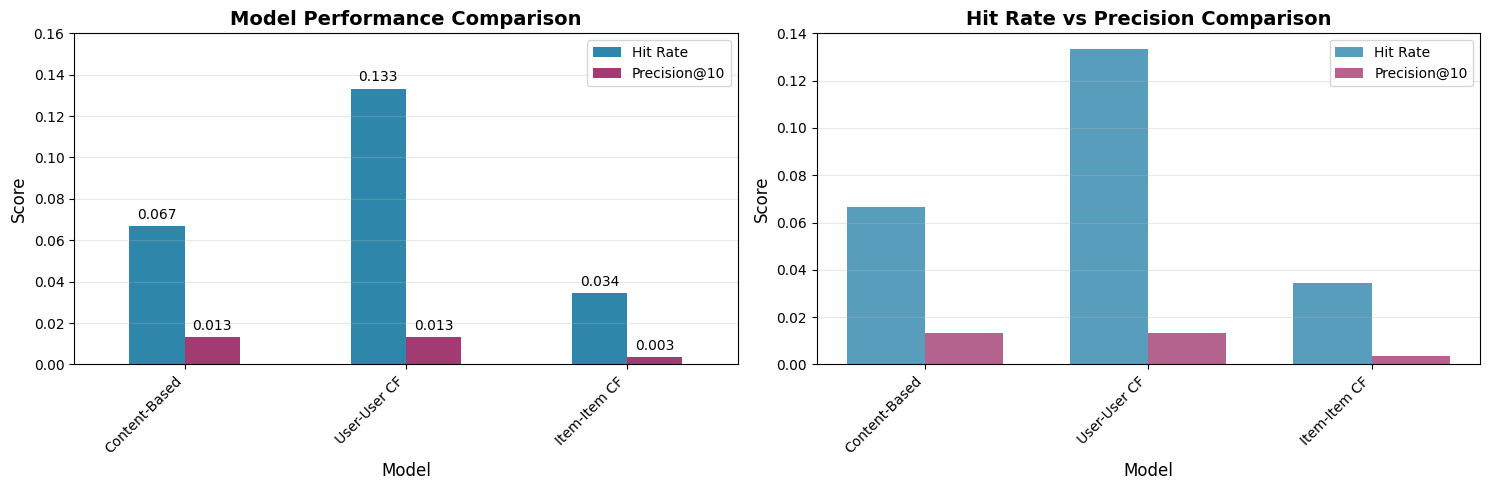

In [59]:
# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot for metrics
metrics_to_plot = ['hit_rate', 'precision']
comparison_plot = comparison_df[metrics_to_plot].copy()
comparison_plot.columns = ['Hit Rate', 'Precision@10']

comparison_plot.plot(kind='bar', ax=axes[0], color=['#2E86AB', '#A23B72'])
axes[0].set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(['Hit Rate', 'Precision@10'])
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim(0, max(comparison_df[metrics_to_plot].max()) * 1.2)

# Add value labels on bars
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.3f', padding=3)

# Grouped bar chart comparing all metrics
x = np.arange(len(comparison_df.index))
width = 0.35

axes[1].bar(x - width/2, comparison_df['hit_rate'], width, label='Hit Rate', alpha=0.8, color='#2E86AB')
axes[1].bar(x + width/2, comparison_df['precision'], width, label='Precision@10', alpha=0.8, color='#A23B72')

axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylabel('Score', fontsize=12)
axes[1].set_title('Hit Rate vs Precision Comparison', fontsize=14, fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(comparison_df.index, rotation=45, ha='right')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [60]:
# Determine best model
print("MODEL RANKING")

# Rank by hit rate
print("\nRanking by Hit Rate:")
hit_rate_ranking = comparison_df['hit_rate'].sort_values(ascending=False)
for rank, (model, score) in enumerate(hit_rate_ranking.items(), 1):
    print(f"  {rank}. {model}: {score:.4f}")

# Rank by precision
print("\nRanking by Precision@10:")
precision_ranking = comparison_df['precision'].sort_values(ascending=False)
for rank, (model, score) in enumerate(precision_ranking.items(), 1):
    print(f"  {rank}. {model}: {score:.4f}")

# Overall best
best_hit_rate = comparison_df['hit_rate'].idxmax()
best_precision = comparison_df['precision'].idxmax()

print(f"Best Hit Rate: {best_hit_rate} ({comparison_df.loc[best_hit_rate, 'hit_rate']:.4f})")
print(f"Best Precision: {best_precision} ({comparison_df.loc[best_precision, 'precision']:.4f})")

MODEL RANKING

Ranking by Hit Rate:
  1. User-User CF: 0.1333
  2. Content-Based: 0.0667
  3. Item-Item CF: 0.0345

Ranking by Precision@10:
  1. Content-Based: 0.0133
  2. User-User CF: 0.0133
  3. Item-Item CF: 0.0034
Best Hit Rate: User-User CF (0.1333)
Best Precision: Content-Based (0.0133)


### Business Insights - Product Category Analysis (3 Models)

BUSINESS INSIGHTS - PRODUCT CATEGORY ANALYSIS

 RECOMMENDATION DIVERSITY BY MODEL

CATEGORY DISTRIBUTION BY MODEL

Content-Based:
  Total unique products recommended: 100
  Number of departments covered: 6
  Top 5 departments:
    - GROCERY: 40 recommendations (40.0%)
    - MEAT: 20 recommendations (20.0%)
    - KIOSK-GAS: 14 recommendations (14.0%)
    - MEAT-PCKGD: 12 recommendations (12.0%)
    - SALAD BAR: 8 recommendations (8.0%)

User-User CF:
  Total unique products recommended: 100
  Number of departments covered: 13
  Top 5 departments:
    - GROCERY: 41 recommendations (42.7%)
    - DRUG GM: 18 recommendations (18.8%)
    - MEAT: 15 recommendations (15.6%)
    - MEAT-PCKGD: 6 recommendations (6.2%)
    - DELI: 6 recommendations (6.2%)

Item-Item CF:
  Total unique products recommended: 100
  Number of departments covered: 11
  Top 5 departments:
    - GROCERY: 41 recommendations (41.0%)
    - DRUG GM: 33 recommendations (33.0%)
    - MEAT-PCKGD: 7 recommendations (7.0%)
    -

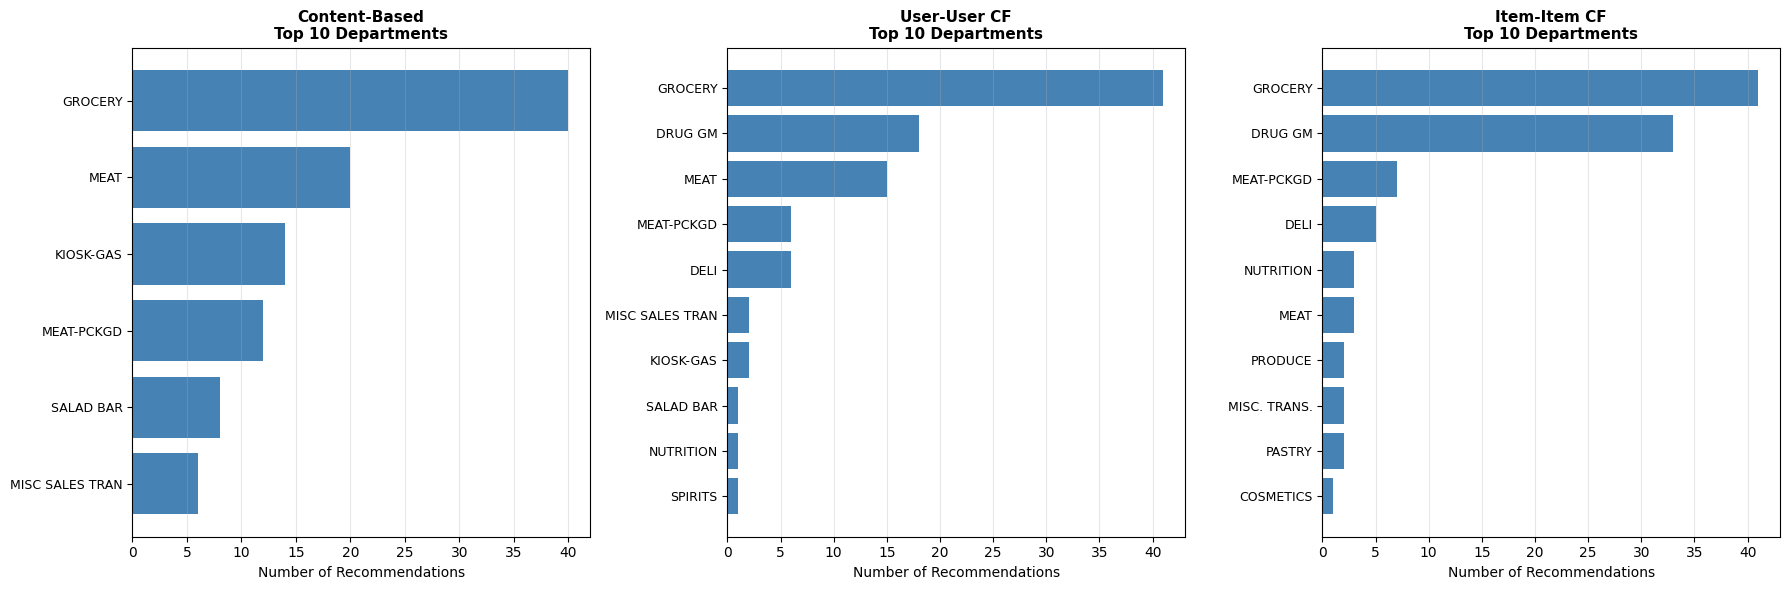


DIVERSITY METRICS COMPARISON

Diversity Metrics:
               unique_products  unique_departments  gini_coefficient
Content-Based            100.0                 6.0          0.346667
User-User CF              96.0                13.0          0.652244
Item-Item CF             100.0                11.0          0.636364

Content-Based:
  - Recommends 100.0 unique products
  - Moderate concentration (Gini=0.347) - BALANCED recommendations

User-User CF:
  - Recommends 96.0 unique products
  - High concentration (Gini=0.652) - FOCUSED on few categories

Item-Item CF:
  - Recommends 100.0 unique products
  - High concentration (Gini=0.636) - FOCUSED on few categories


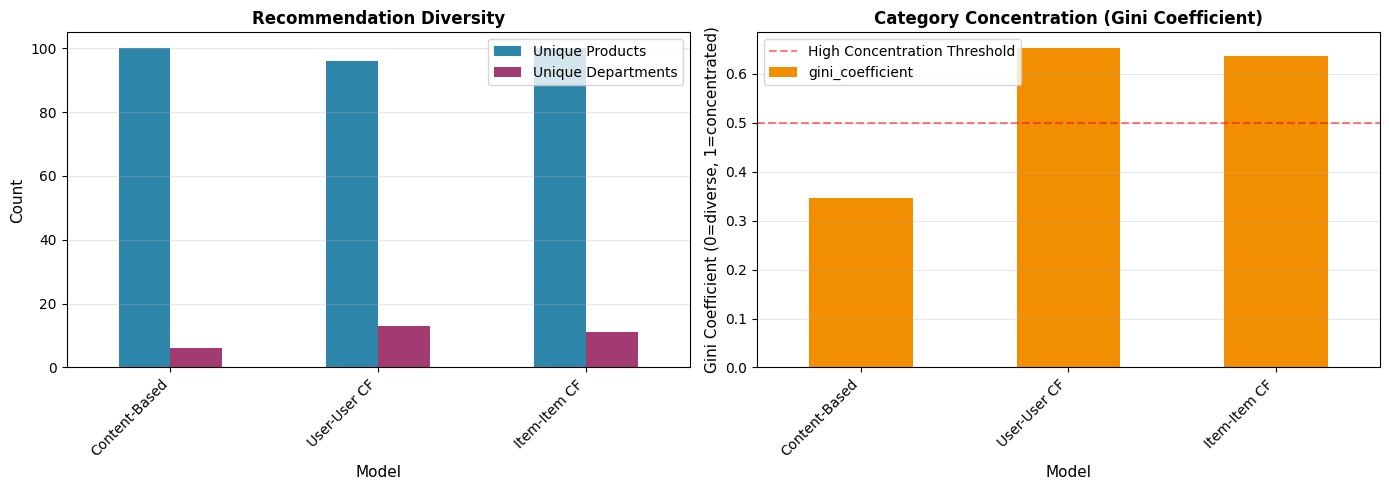

In [62]:
print("BUSINESS INSIGHTS - PRODUCT CATEGORY ANALYSIS")

# Analyze recommendation patterns for each model
print("\n RECOMMENDATION DIVERSITY BY MODEL")

# Get sample users for analysis
analysis_users = sample_users[:10]  # Analyze 10 users

model_recommendations = {
    'Content-Based': {},
    'User-User CF': {},
    'Item-Item CF': {}
}

for user in analysis_users:
    # Content-Based
    try:
        cb_recs = get_user_content_recommendations(
            user, train_data, product_encoded, product_encoded_sparse, n_recommendations=20
        )
        model_recommendations['Content-Based'][user] = cb_recs
    except:
        model_recommendations['Content-Based'][user] = pd.Series()
    
    # User-User CF
    if user in train_pivot.index:
        try:
            uu_recs = get_user_user_recommendations(
                user, train_pivot, user_similarity_df, n_recommendations=20, k=20
            )
            model_recommendations['User-User CF'][user] = uu_recs
        except:
            model_recommendations['User-User CF'][user] = pd.Series()
    
    # Item-Item CF
    if user in train_pivot.index:
        try:
            ii_recs = get_item_item_recommendations_optimized(
                user, train_pivot, item_user_sparse, item_user_index, n_recommendations=20, k=20
            )
            model_recommendations['Item-Item CF'][user] = ii_recs
        except:
            model_recommendations['Item-Item CF'][user] = pd.Series()

# Analyze category distribution for each model
def get_category_distribution(recommendations_dict, product_data):
    all_products = []
    for user_recs in recommendations_dict.values():
        if len(user_recs) > 0:
            all_products.extend(user_recs.index.tolist())
    
    if len(all_products) == 0:
        return pd.Series()
    
    rec_products = product_data[product_data['PRODUCT_ID'].isin(all_products)]
    category_dist = rec_products['DEPARTMENT'].value_counts()
    return category_dist

print("\nCATEGORY DISTRIBUTION BY MODEL")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, (model_name, recs_dict) in enumerate(model_recommendations.items()):
    category_dist = get_category_distribution(recs_dict, product)
    
    print(f"\n{model_name}:")
    print(f"  Total unique products recommended: {sum(len(set(r.index)) for r in recs_dict.values() if len(r) > 0)}")
    print(f"  Number of departments covered: {len(category_dist)}")
    
    if len(category_dist) > 0:
        print(f"  Top 5 departments:")
        for dept, count in category_dist.head(5).items():
            print(f"    - {dept}: {count} recommendations ({count/category_dist.sum()*100:.1f}%)")
        
        # Visualize top 10 departments
        top_depts = category_dist.head(10)
        axes[idx].barh(range(len(top_depts)), top_depts.values, color='steelblue')
        axes[idx].set_yticks(range(len(top_depts)))
        axes[idx].set_yticklabels([dept[:25] + '...' if len(dept) > 25 else dept for dept in top_depts.index], fontsize=9)
        axes[idx].set_xlabel('Number of Recommendations', fontsize=10)
        axes[idx].set_title(f'{model_name}\nTop 10 Departments', fontsize=11, fontweight='bold')
        axes[idx].invert_yaxis()
        axes[idx].grid(axis='x', alpha=0.3)
    else:
        axes[idx].text(0.5, 0.5, 'No recommendations', ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{model_name}', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

# Compare diversity metrics
print("\nDIVERSITY METRICS COMPARISON")

diversity_metrics = {}

for model_name, recs_dict in model_recommendations.items():
    # Calculate unique products
    all_products = set()
    for user_recs in recs_dict.values():
        if len(user_recs) > 0:
            all_products.update(user_recs.index.tolist())
    
    # Calculate unique departments
    if len(all_products) > 0:
        rec_products = product[product['PRODUCT_ID'].isin(all_products)]
        unique_depts = rec_products['DEPARTMENT'].nunique()
        
        # Calculate Gini coefficient (concentration measure)
        category_dist = get_category_distribution(recs_dict, product)
        if len(category_dist) > 0:
            sorted_counts = np.sort(category_dist.values)
            n = len(sorted_counts)
            gini = (2 * np.sum((np.arange(1, n+1)) * sorted_counts)) / (n * np.sum(sorted_counts)) - (n + 1) / n
        else:
            gini = 0
    else:
        unique_depts = 0
        gini = 0
    
    diversity_metrics[model_name] = {
        'unique_products': len(all_products),
        'unique_departments': unique_depts,
        'gini_coefficient': gini
    }

diversity_df = pd.DataFrame(diversity_metrics).T

print("\nDiversity Metrics:")
print(diversity_df)

for model in diversity_df.index:
    gini = diversity_df.loc[model, 'gini_coefficient']
    products = diversity_df.loc[model, 'unique_products']
    
    print(f"\n{model}:")
    print(f"  - Recommends {products} unique products")
    
    if gini < 0.3:
        print(f"  - Low concentration (Gini={gini:.3f}) - DIVERSE recommendations across categories")
    elif gini < 0.5:
        print(f"  - Moderate concentration (Gini={gini:.3f}) - BALANCED recommendations")
    else:
        print(f"  - High concentration (Gini={gini:.3f}) - FOCUSED on few categories")

# Visualize diversity comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Unique products and departments
diversity_df[['unique_products', 'unique_departments']].plot(kind='bar', ax=axes[0], color=['#2E86AB', '#A23B72'])
axes[0].set_title('Recommendation Diversity', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Model', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].legend(['Unique Products', 'Unique Departments'])
axes[0].grid(axis='y', alpha=0.3)

# Gini coefficient
diversity_df['gini_coefficient'].plot(kind='bar', ax=axes[1], color='#F18F01')
axes[1].set_title('Category Concentration (Gini Coefficient)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Model', fontsize=11)
axes[1].set_ylabel('Gini Coefficient (0=diverse, 1=concentrated)', fontsize=11)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='High Concentration Threshold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()